<a href="https://colab.research.google.com/github/rubycho/cv-notes/blob/master/CV02/CV02%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Segmentation

Try segmentation with pet images.

This code is from keras: ["Image segmentation with a U-net-like architecture"](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

### Prepare images

Dataset from Oxford.

In [2]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0   9.8M      0  0:01:16  0:01:16 --:--:-- 10.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  3881k      0  0:00:04  0:00:04 --:--:-- 4553k


In [3]:
import os

input_dir = 'images/'
target_dir = 'annotations/trimaps/'

img_size = (160, 160)
num_classes = 4
batch_size = 32

input_img_paths = sorted(
    [
      os.path.join(input_dir, fname) 
      for fname in os.listdir(input_dir)
      if fname.endswith('.jpg')
    ]
)

target_img_paths = sorted(
    [
      os.path.join(target_dir, fname)
      for fname in os.listdir(target_dir)
      if fname.endswith('.png') and not fname.startswith('.')
    ]
)

print("Number of examples: ", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
  print(input_path, '|', target_path)

Number of examples:  7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


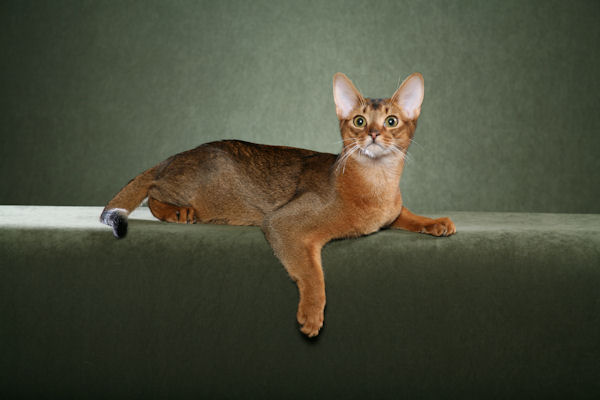

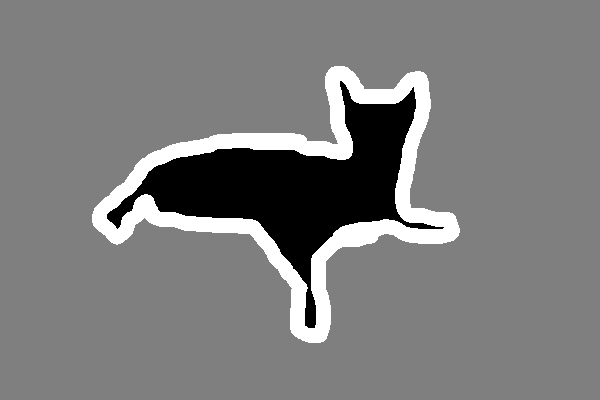


img[180:220, 180:220, 0]: 
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


In [23]:
import PIL
from PIL import ImageOps

import numpy as np

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img

idx = 0
display(Image(filename=input_img_paths[idx]))

img = load_img(target_img_paths[idx])
np_img = np.asarray(img)

img = PIL.ImageOps.autocontrast(img)
display(img)

print()
print('img[180:220, 180:220, 0]: \n')
print(np_img[180:220, 180:220, 0])

In [ ]:
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

class OxfordPets(keras.utils.Sequence):
  """
  Helper to iterate over the data
  """

  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i: i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]

    x = np.zeros((batch_size,) + self.img_size + (3,), dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      x[j] = load_img(path, target_size=self.img_size)
    
    y = np.zeros((batch_size,) + self.img_size + (1,), dtype='uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.img_size, color_mode='grayscale')
      y[j] = np.expand_dims(img, 2)
    return x, y

In [ ]:
# U-net Xception style model

from tensorflow.keras import layers


def get_model(img_size, num_classes):
  inputs = layers.Input(shape=img_size+(3,))
  
  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x

  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(
        previous_block_activation
    )
    x = layers.add([x, residual])
    previous_block_activation = x
  
  previous_block_activation = x

  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    previous_block_activation = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
  
  model = keras.Model(inputs, outputs)
  return model

keras.backend.clear_session()
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

callbacks = [
  keras.callbacks.ModelCheckpoint('oxford_segmentation.h5', save_best_only=True)
]

epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 80s 404ms/step - loss: 0.7917 - val_loss: 2.1890
Epoch 2/15
199/199 [==============================] - 80s 402ms/step - loss: 0.5172 - val_loss: 2.7269
Epoch 3/15
199/199 [==============================] - 80s 402ms/step - loss: 0.4490 - val_loss: 0.7072
Epoch 4/15
199/199 [==============================] - 80s 402ms/step - loss: 0.4019 - val_loss: 0.4284
Epoch 5/15
199/199 [==============================] - 80s 401ms/step - loss: 0.3729 - val_loss: 0.4191
Epoch 6/15
199/199 [==============================] - 80s 403ms/step - loss: 0.3451 - val_loss: 0.4012
Epoch 7/15
199/199 [==============================] - 80s 401ms/step - loss: 0.3204 - val_loss: 0.4273
Epoch 8/15
199/199 [==============================] - 80s 401ms/step - loss: 0.3008 - val_loss: 0.4127
Epoch 9/15
199/199 [==============================] - 80s 401ms/step - loss: 0.2781 - val_loss: 0.4486
Epoch 10/15
199/199 [==============================] - 80s 401ms/step - l

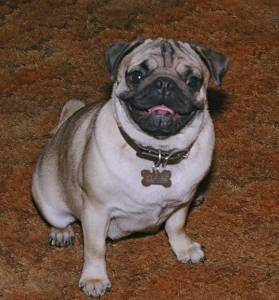

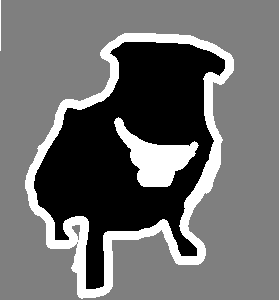

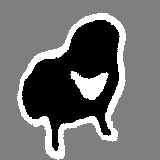

In [ ]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
  mask = np.argmax(val_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)

i = 10

display(Image(filename=val_input_img_paths[i]))

img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

display_mask(i)